In [17]:
import pandas as pd
from pandas import read_csv
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import glob

In [12]:
def sMAPE(a, b):
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()

In [13]:
def rmsle(y, y_pred):     
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def lstm_multivariate(filename):
    
    values = filename.values
    
    # integer encode direction
    encoder = LabelEncoder()
    values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[10,11,11,12,13,14,15,16,17]], axis=1, inplace=True)
    print(reframed.head())
    
    
    # split into train and test sets
    print("Splitting into train and test")
    values = reframed.values
    n_train_hours = 33600
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    
    # design network
    print("Designing network")
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
   
    # fit network
    print("Fitting network")
    history = model.fit(train_X, train_y, epochs=5, batch_size=70,validation_split=0.04,validation_data=(test_X, test_y), verbose=1, shuffle=False)
    
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    #Metrics
    print('Calculating metrics')
    mape_i = sMAPE(inv_y, inv_yhat)
    rmsle_i = rmsle(inv_y, inv_yhat)
    
    return mape_i, rmsle_i


filename number 1
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.018010   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.058319   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.043739   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.051458   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.086621   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058319  
2   0.403581   0.909091        1.0  0.043739  
3   0.414601   0.870130        1.0  0.051458  
4   0.414601   0.870130        1.0  0.086621  
5   0.362948   0.883117        1.0  0.072041  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0242 - val_loss: 0.0307
Epoch 2/5
33

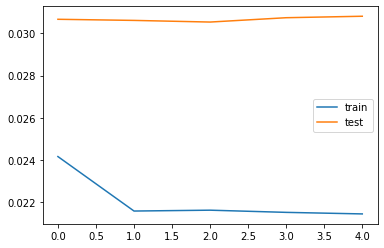

Calculating metrics
filename number 2
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.311614   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.245399   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.210493   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.232494   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.286863   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.245399  
2   0.403581   0.909091        1.0  0.210493  
3   0.414601   0.870130        1.0  0.232494  
4   0.414601   0.870130        1.0  0.286863  
5   0.362948   0.883117        1.0  0.136873  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0501 - val_loss:

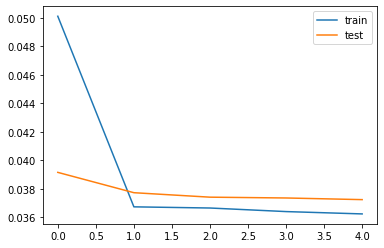

Calculating metrics
filename number 3
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.213094   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.180745   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.217458   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.214377   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.204365   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.180745  
2   0.403581   0.909091        1.0  0.217458  
3   0.414601   0.870130        1.0  0.214377  
4   0.414601   0.870130        1.0  0.204365  
5   0.362948   0.883117        1.0  0.156611  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 91us/step - loss: 0.0591 - val_loss:

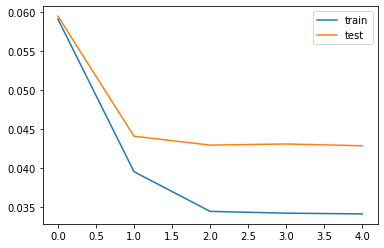

Calculating metrics
filename number 4
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.122598   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.130833   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.176578   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.032022   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.035682   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.130833  
2   0.403581   0.909091        1.0  0.176578  
3   0.414601   0.870130        1.0  0.032022  
4   0.414601   0.870130        1.0  0.035682  
5   0.362948   0.883117        1.0  0.039341  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0302 - val_loss:

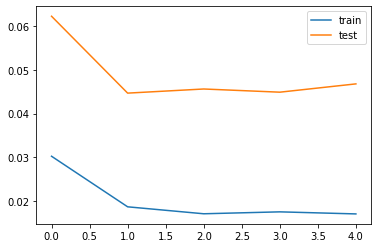

Calculating metrics
filename number 5
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.057228   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.045737   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.068490   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.046426   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.036773   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.045737  
2   0.403581   0.909091        1.0  0.068490  
3   0.414601   0.870130        1.0  0.046426  
4   0.414601   0.870130        1.0  0.036773  
5   0.362948   0.883117        1.0  0.033096  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0290 - val_loss:

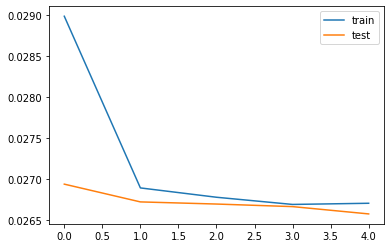

Calculating metrics
filename number 6
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.124530   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.105713   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.091345   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044817   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.037975   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.105713  
2   0.403581   0.909091        1.0  0.091345  
3   0.414601   0.870130        1.0  0.044817  
4   0.414601   0.870130        1.0  0.037975  
5   0.362948   0.883117        1.0  0.026001  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0443 - val_loss:

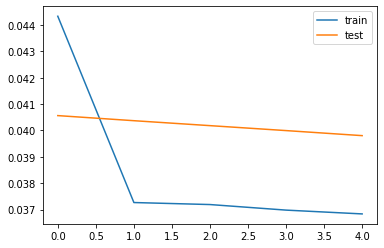

Calculating metrics
filename number 7
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065983   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.068225   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.067585   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.115631   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.065022   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068225  
2   0.403581   0.909091        1.0  0.067585  
3   0.414601   0.870130        1.0  0.115631  
4   0.414601   0.870130        1.0  0.065022  
5   0.362948   0.883117        1.0  0.059898  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0533 - val_loss:

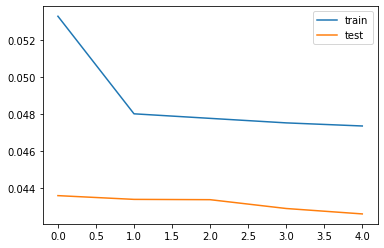

Calculating metrics
filename number 8
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.081356   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.056497   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.039171   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044444   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.023352   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.056497  
2   0.403581   0.909091        1.0  0.039171  
3   0.414601   0.870130        1.0  0.044444  
4   0.414601   0.870130        1.0  0.023352  
5   0.362948   0.883117        1.0  0.044068  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0264 - val_loss:

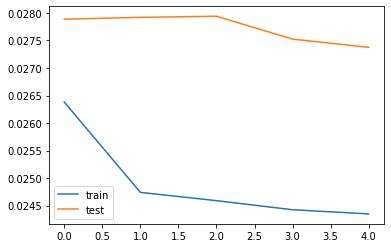

Calculating metrics
filename number 9
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.117481   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.123120   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.114662   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.108083   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.073778   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.123120  
2   0.403581   0.909091        1.0  0.114662  
3   0.414601   0.870130        1.0  0.108083  
4   0.414601   0.870130        1.0  0.073778  
5   0.362948   0.883117        1.0  0.073543  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0493 - val_loss:

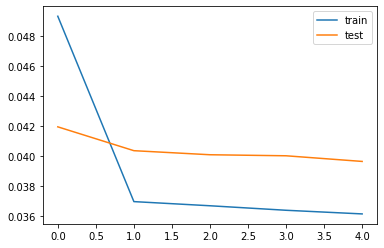

Calculating metrics
filename number 10
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.091274   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.090772   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.048144   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.023069   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.016550   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090772  
2   0.403581   0.909091        1.0  0.048144  
3   0.414601   0.870130        1.0  0.023069  
4   0.414601   0.870130        1.0  0.016550  
5   0.362948   0.883117        1.0  0.017553  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0390 - val_loss

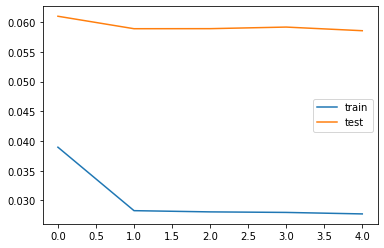

Calculating metrics
filename number 11
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.060081   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.050577   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.051595   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.039036   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.038697   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.050577  
2   0.403581   0.909091        1.0  0.051595  
3   0.414601   0.870130        1.0  0.039036  
4   0.414601   0.870130        1.0  0.038697  
5   0.362948   0.883117        1.0  0.050577  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 93us/step - loss: 0.0377 - val_loss

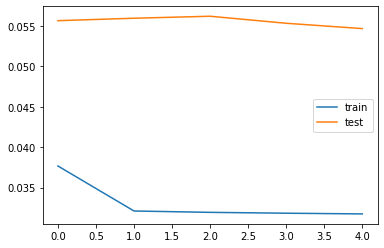

Calculating metrics
filename number 12
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041738   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.458046   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.380594   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.511403   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.347676   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.458046  
2   0.403581   0.909091        1.0  0.380594  
3   0.414601   0.870130        1.0  0.511403  
4   0.414601   0.870130        1.0  0.347676  
5   0.362948   0.883117        1.0  0.314974  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0402 - val_loss

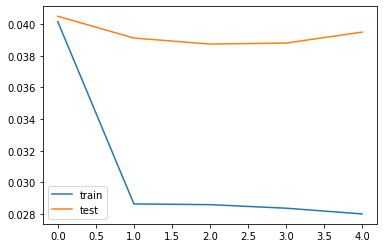

Calculating metrics
filename number 13
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.032312   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.033977   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.031312   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030979   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.031312   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033977  
2   0.403581   0.909091        1.0  0.031312  
3   0.414601   0.870130        1.0  0.030979  
4   0.414601   0.870130        1.0  0.031312  
5   0.362948   0.883117        1.0  0.031646  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0208 - val_loss

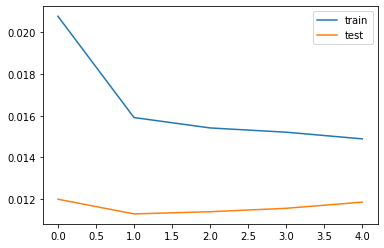

Calculating metrics
filename number 14
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.148114   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.303588   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.226311   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.133395   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044158   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.303588  
2   0.403581   0.909091        1.0  0.226311  
3   0.414601   0.870130        1.0  0.133395  
4   0.414601   0.870130        1.0  0.044158  
5   0.362948   0.883117        1.0  0.053358  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0413 - val_loss

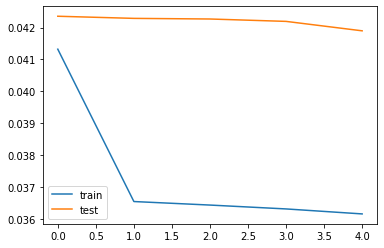

Calculating metrics
filename number 15
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.042271   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.042271   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.042902   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.043533   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.043533   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.042271  
2   0.403581   0.909091        1.0  0.042902  
3   0.414601   0.870130        1.0  0.043533  
4   0.414601   0.870130        1.0  0.043533  
5   0.362948   0.883117        1.0  0.042902  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0351 - val_loss

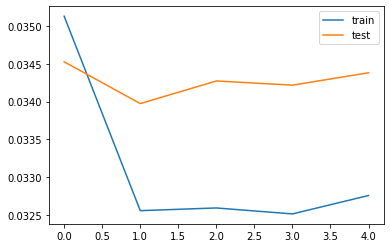

Calculating metrics
filename number 16
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.074850   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.060878   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.025449   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.035928   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044411   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.060878  
2   0.403581   0.909091        1.0  0.025449  
3   0.414601   0.870130        1.0  0.035928  
4   0.414601   0.870130        1.0  0.044411  
5   0.362948   0.883117        1.0  0.021457  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0350 - val_loss

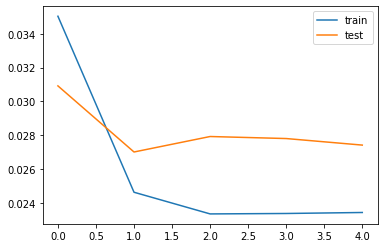

Calculating metrics
filename number 17
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.023029   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.023279   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.057572   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.037297   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044055   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.023279  
2   0.403581   0.909091        1.0  0.057572  
3   0.414601   0.870130        1.0  0.037297  
4   0.414601   0.870130        1.0  0.044055  
5   0.362948   0.883117        1.0  0.030288  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0240 - val_loss

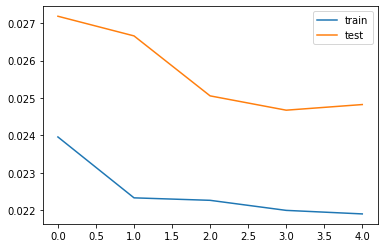

Calculating metrics
filename number 18
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.018817   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.018049   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.019201   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009601   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011905   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.018049  
2   0.403581   0.909091        1.0  0.019201  
3   0.414601   0.870130        1.0  0.009601  
4   0.414601   0.870130        1.0  0.011905  
5   0.362948   0.883117        1.0  0.012673  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0471 - val_loss

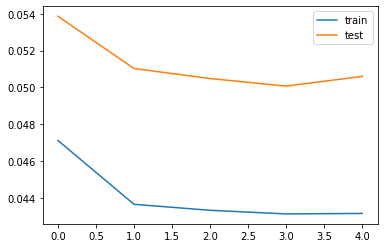

Calculating metrics
filename number 19
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.104306   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.100478   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.111962   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.105263   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.047847   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.100478  
2   0.403581   0.909091        1.0  0.111962  
3   0.414601   0.870130        1.0  0.105263  
4   0.414601   0.870130        1.0  0.047847  
5   0.362948   0.883117        1.0  0.044019  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0374 - val_loss

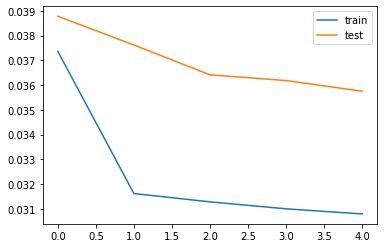

Calculating metrics
filename number 20
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025372   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027303   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.059846   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030061   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.006343   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027303  
2   0.403581   0.909091        1.0  0.059846  
3   0.414601   0.870130        1.0  0.030061  
4   0.414601   0.870130        1.0  0.006343  
5   0.362948   0.883117        1.0  0.006343  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0637 - val_loss

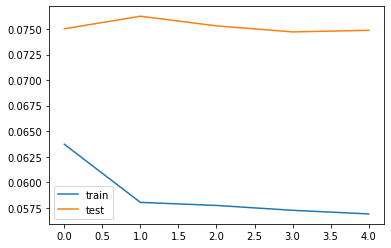

Calculating metrics
filename number 21
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098958   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.098090   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.098090   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.085069   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.052083   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.098090  
2   0.403581   0.909091        1.0  0.098090  
3   0.414601   0.870130        1.0  0.085069  
4   0.414601   0.870130        1.0  0.052083  
5   0.362948   0.883117        1.0  0.047743  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0415 - val_loss

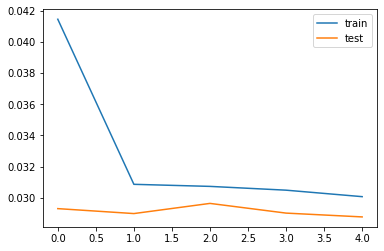

Calculating metrics
filename number 22
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.011507   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.001918   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006904   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.014960   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007672   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.001918  
2   0.403581   0.909091        1.0  0.006904  
3   0.414601   0.870130        1.0  0.014960  
4   0.414601   0.870130        1.0  0.007672  
5   0.362948   0.883117        1.0  0.013425  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0188 - val_loss

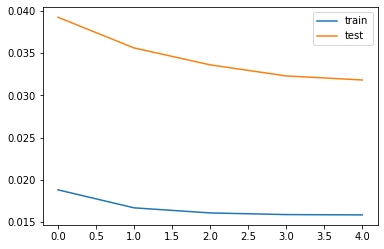

Calculating metrics
filename number 23
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.013415   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.001524   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.019817   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.002134   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.014024   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.001524  
2   0.403581   0.909091        1.0  0.019817  
3   0.414601   0.870130        1.0  0.002134  
4   0.414601   0.870130        1.0  0.014024  
5   0.362948   0.883117        1.0  0.007927  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0578 - val_loss

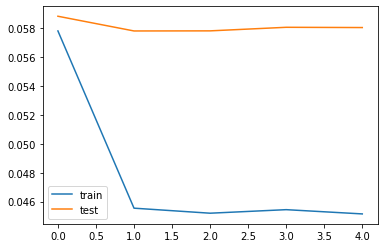

Calculating metrics
filename number 24
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.024534   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.015750   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.084507   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.047100   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.038922   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015750  
2   0.403581   0.909091        1.0  0.084507  
3   0.414601   0.870130        1.0  0.047100  
4   0.414601   0.870130        1.0  0.038922  
5   0.362948   0.883117        1.0  0.031501  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0612 - val_loss

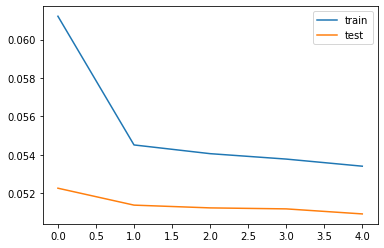

Calculating metrics
filename number 25
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.007401   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.012240   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.304014   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.197267   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.195275   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.012240  
2   0.403581   0.909091        1.0  0.304014  
3   0.414601   0.870130        1.0  0.197267  
4   0.414601   0.870130        1.0  0.195275  
5   0.362948   0.883117        1.0  0.190436  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0714 - val_loss

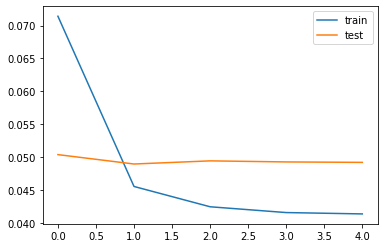

Calculating metrics
filename number 26
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.023299   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032914   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.033654   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031805   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.024408   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032914  
2   0.403581   0.909091        1.0  0.033654  
3   0.414601   0.870130        1.0  0.031805  
4   0.414601   0.870130        1.0  0.024408  
5   0.362948   0.883117        1.0  0.025148  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0246 - val_loss

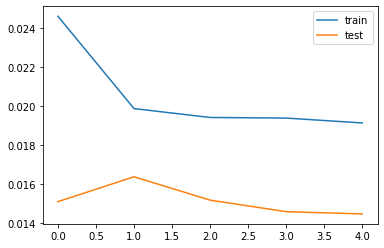

Calculating metrics
filename number 27
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.059770   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.065900   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058238   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.134100   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.129502   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.065900  
2   0.403581   0.909091        1.0  0.058238  
3   0.414601   0.870130        1.0  0.134100  
4   0.414601   0.870130        1.0  0.129502  
5   0.362948   0.883117        1.0  0.032950  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0402 - val_loss

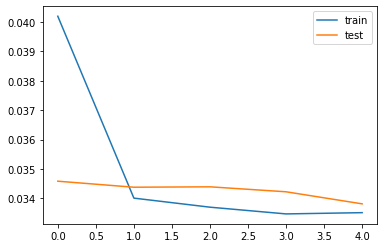

Calculating metrics
filename number 28
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.100623   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.085290   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.077144   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.047916   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.069957   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.085290  
2   0.403581   0.909091        1.0  0.077144  
3   0.414601   0.870130        1.0  0.047916  
4   0.414601   0.870130        1.0  0.069957  
5   0.362948   0.883117        1.0  0.063728  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0464 - val_loss

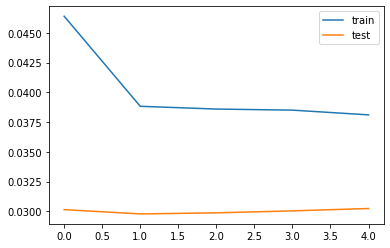

Calculating metrics
filename number 29
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.177316   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.164438   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.159485   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.120357   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.067360   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.164438  
2   0.403581   0.909091        1.0  0.159485  
3   0.414601   0.870130        1.0  0.120357  
4   0.414601   0.870130        1.0  0.067360  
5   0.362948   0.883117        1.0  0.018326  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 915s 27ms/step - loss: 0.0498 - val_lo

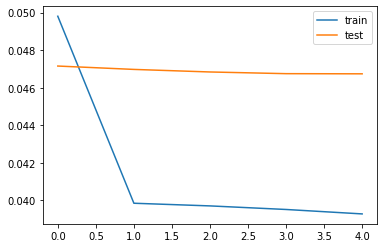

Calculating metrics
filename number 30
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.173390   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.192009   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.177657   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.182700   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.169123   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.192009  
2   0.403581   0.909091        1.0  0.177657  
3   0.414601   0.870130        1.0  0.182700  
4   0.414601   0.870130        1.0  0.169123  
5   0.362948   0.883117        1.0  0.132273  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0417 - val_loss

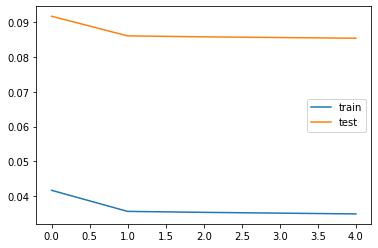

Calculating metrics
filename number 31
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080729   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.038021   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.022917   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.029688   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.026563   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.038021  
2   0.403581   0.909091        1.0  0.022917  
3   0.414601   0.870130        1.0  0.029688  
4   0.414601   0.870130        1.0  0.026563  
5   0.362948   0.883117        1.0  0.010938  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 81us/step - loss: 0.0262 - val_loss

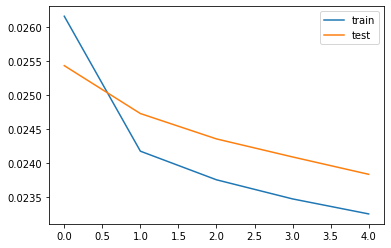

Calculating metrics
filename number 32
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028298   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027258   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.025801   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.029963   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.049313   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027258  
2   0.403581   0.909091        1.0  0.025801  
3   0.414601   0.870130        1.0  0.029963  
4   0.414601   0.870130        1.0  0.049313  
5   0.362948   0.883117        1.0  0.004786  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0263 - val_loss

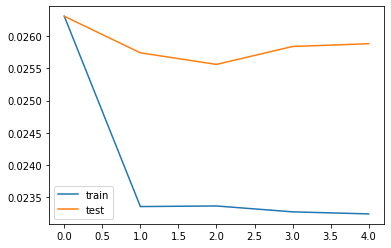

Calculating metrics
filename number 33
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.077030   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.006708   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.054823   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.001157   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.003701   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.006708  
2   0.403581   0.909091        1.0  0.054823  
3   0.414601   0.870130        1.0  0.001157  
4   0.414601   0.870130        1.0  0.003701  
5   0.362948   0.883117        1.0  0.000463  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0310 - val_loss

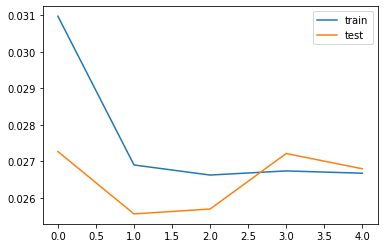

Calculating metrics
filename number 34
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065322   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.059358   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.045726   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.059358   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.047430   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.059358  
2   0.403581   0.909091        1.0  0.045726  
3   0.414601   0.870130        1.0  0.059358  
4   0.414601   0.870130        1.0  0.047430  
5   0.362948   0.883117        1.0  0.050270  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0441 - val_loss

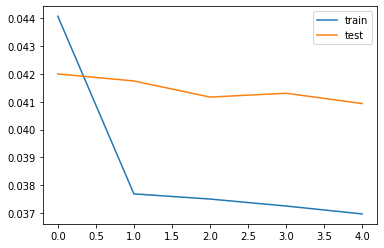

Calculating metrics
filename number 35
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.014099   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.014443   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.043329   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.048487   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.035076   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.014443  
2   0.403581   0.909091        1.0  0.043329  
3   0.414601   0.870130        1.0  0.048487  
4   0.414601   0.870130        1.0  0.035076  
5   0.362948   0.883117        1.0  0.033700  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 55us/step - loss: 0.0276 - val_loss

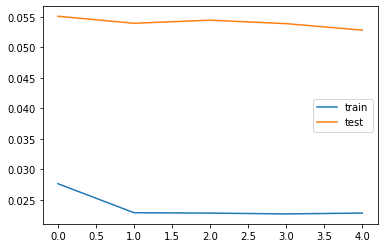

Calculating metrics
filename number 36
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.016577   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.025841   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.008289   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.005363   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.005363   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.025841  
2   0.403581   0.909091        1.0  0.008289  
3   0.414601   0.870130        1.0  0.005363  
4   0.414601   0.870130        1.0  0.005363  
5   0.362948   0.883117        1.0  0.022428  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0248 - val_loss

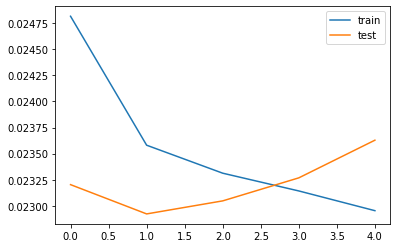

Calculating metrics
filename number 37
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064704   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.077584   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.065011   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.026372   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.010733   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.077584  
2   0.403581   0.909091        1.0  0.065011  
3   0.414601   0.870130        1.0  0.026372  
4   0.414601   0.870130        1.0  0.010733  
5   0.362948   0.883117        1.0  0.018399  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0315 - val_loss

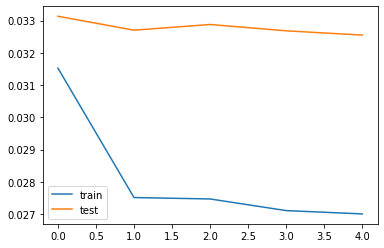

Calculating metrics
filename number 38
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008696   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.019324   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.037681   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009662   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.017391   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.019324  
2   0.403581   0.909091        1.0  0.037681  
3   0.414601   0.870130        1.0  0.009662  
4   0.414601   0.870130        1.0  0.017391  
5   0.362948   0.883117        1.0  0.039614  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0333 - val_loss

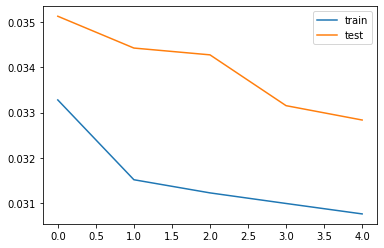

Calculating metrics
filename number 39
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.118151   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.114516   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.112698   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.128538   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.198909   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.114516  
2   0.403581   0.909091        1.0  0.112698  
3   0.414601   0.870130        1.0  0.128538  
4   0.414601   0.870130        1.0  0.198909  
5   0.362948   0.883117        1.0  0.119709  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0357 - val_loss

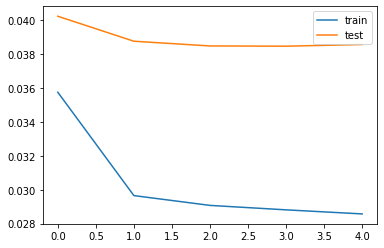

Calculating metrics
filename number 40
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.039086   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032448   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006637   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031711   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018437   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032448  
2   0.403581   0.909091        1.0  0.006637  
3   0.414601   0.870130        1.0  0.031711  
4   0.414601   0.870130        1.0  0.018437  
5   0.362948   0.883117        1.0  0.011062  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 83us/step - loss: 0.0264 - val_loss

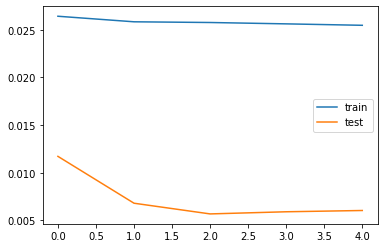

Calculating metrics
filename number 41
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.013730   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.021358   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.012586   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.020214   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020595   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.021358  
2   0.403581   0.909091        1.0  0.012586  
3   0.414601   0.870130        1.0  0.020214  
4   0.414601   0.870130        1.0  0.020595  
5   0.362948   0.883117        1.0  0.011823  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0265 - val_loss

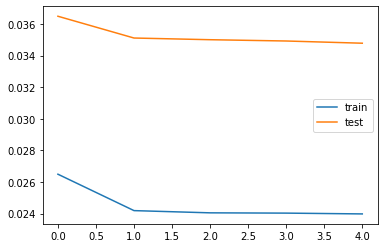

Calculating metrics
filename number 42
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098323   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.056680   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.009254   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.006362   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.017351   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.056680  
2   0.403581   0.909091        1.0  0.009254  
3   0.414601   0.870130        1.0  0.006362  
4   0.414601   0.870130        1.0  0.017351  
5   0.362948   0.883117        1.0  0.000000  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0381 - val_loss

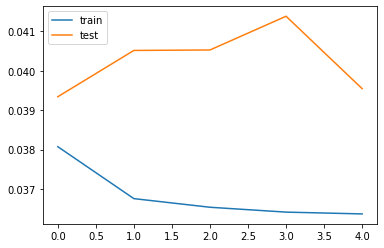

Calculating metrics
filename number 43
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.040238   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032414   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.041915   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.017511   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.013413   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032414  
2   0.403581   0.909091        1.0  0.041915  
3   0.414601   0.870130        1.0  0.017511  
4   0.414601   0.870130        1.0  0.013413  
5   0.362948   0.883117        1.0  0.013040  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0334 - val_loss

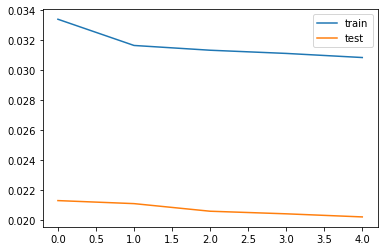

Calculating metrics
filename number 44
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.132273   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.121786   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.123478   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.156292   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.111299   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.121786  
2   0.403581   0.909091        1.0  0.123478  
3   0.414601   0.870130        1.0  0.156292  
4   0.414601   0.870130        1.0  0.111299  
5   0.362948   0.883117        1.0  0.072057  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 78us/step - loss: 0.0442 - val_loss

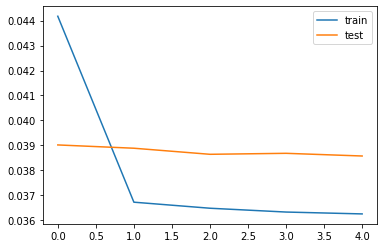

Calculating metrics
filename number 45
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.034779   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.042508   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.030056   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.048519   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.031773   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.042508  
2   0.403581   0.909091        1.0  0.030056  
3   0.414601   0.870130        1.0  0.048519  
4   0.414601   0.870130        1.0  0.031773  
5   0.362948   0.883117        1.0  0.034350  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 88us/step - loss: 0.0406 - val_loss

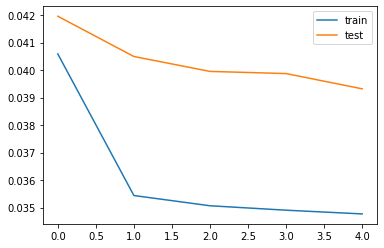

Calculating metrics
filename number 46
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.006555   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.005827   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006555   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.005827   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011653   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.005827  
2   0.403581   0.909091        1.0  0.006555  
3   0.414601   0.870130        1.0  0.005827  
4   0.414601   0.870130        1.0  0.011653  
5   0.362948   0.883117        1.0  0.005827  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 95us/step - loss: 0.0251 - val_loss

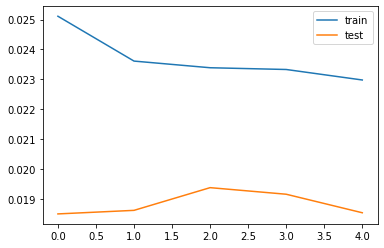

Calculating metrics
filename number 47
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.002917   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.006007   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.001373   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.002746   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.006521   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.006007  
2   0.403581   0.909091        1.0  0.001373  
3   0.414601   0.870130        1.0  0.002746  
4   0.414601   0.870130        1.0  0.006521  
5   0.362948   0.883117        1.0  0.001373  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 86us/step - loss: 0.0133 - val_loss

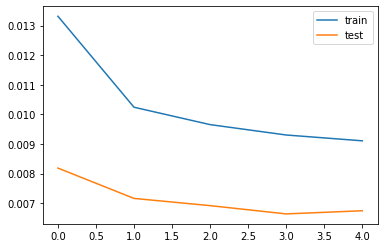

Calculating metrics
filename number 48
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.085754   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.086215   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.071462   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.054864   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020286   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.086215  
2   0.403581   0.909091        1.0  0.071462  
3   0.414601   0.870130        1.0  0.054864  
4   0.414601   0.870130        1.0  0.020286  
5   0.362948   0.883117        1.0  0.018442  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 82us/step - loss: 0.0453 - val_loss

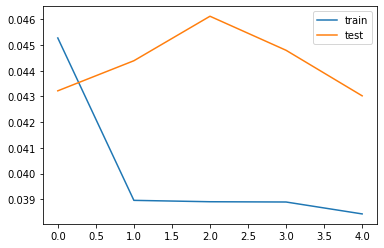

Calculating metrics
filename number 49
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.066072   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.068189   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.065165   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.065770   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.066979   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068189  
2   0.403581   0.909091        1.0  0.065165  
3   0.414601   0.870130        1.0  0.065770  
4   0.414601   0.870130        1.0  0.066979  
5   0.362948   0.883117        1.0  0.060931  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 82us/step - loss: 0.0524 - val_loss

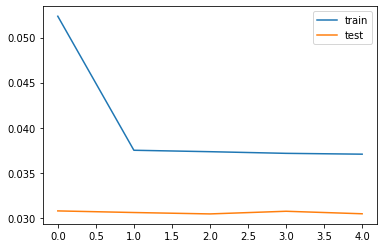

Calculating metrics
filename number 50
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.071583   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.083094   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.089568   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.089209   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.058273   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.083094  
2   0.403581   0.909091        1.0  0.089568  
3   0.414601   0.870130        1.0  0.089209  
4   0.414601   0.870130        1.0  0.058273  
5   0.362948   0.883117        1.0  0.040647  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 80us/step - loss: 0.0312 - val_loss

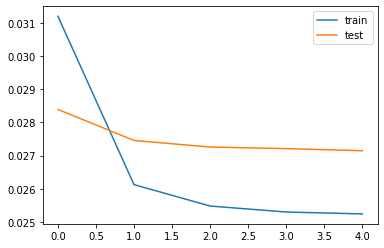

Calculating metrics
filename number 51
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.078571   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.090909   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.088312   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.097403   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.091558   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090909  
2   0.403581   0.909091        1.0  0.088312  
3   0.414601   0.870130        1.0  0.097403  
4   0.414601   0.870130        1.0  0.091558  
5   0.362948   0.883117        1.0  0.048701  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0422 - val_loss

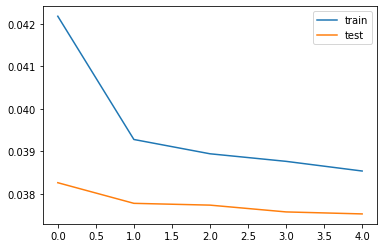

Calculating metrics
filename number 52
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.135900   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.129672   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.095696   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.093431   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.093431   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.129672  
2   0.403581   0.909091        1.0  0.095696  
3   0.414601   0.870130        1.0  0.093431  
4   0.414601   0.870130        1.0  0.093431  
5   0.362948   0.883117        1.0  0.062288  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0426 - val_loss

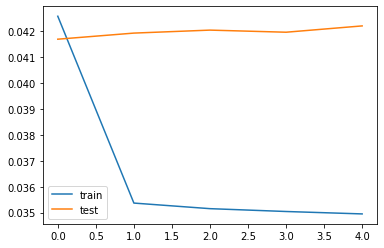

Calculating metrics
filename number 53
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.183206   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.176266   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.154060   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.147120   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.166551   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.176266  
2   0.403581   0.909091        1.0  0.154060  
3   0.414601   0.870130        1.0  0.147120  
4   0.414601   0.870130        1.0  0.166551  
5   0.362948   0.883117        1.0  0.118668  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0365 - val_loss

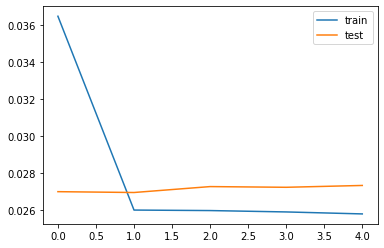

Calculating metrics
filename number 54
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028140   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.029703   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.030224   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.086503   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046378   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.029703  
2   0.403581   0.909091        1.0  0.030224  
3   0.414601   0.870130        1.0  0.086503  
4   0.414601   0.870130        1.0  0.046378  
5   0.362948   0.883117        1.0  0.027097  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0249 - val_loss

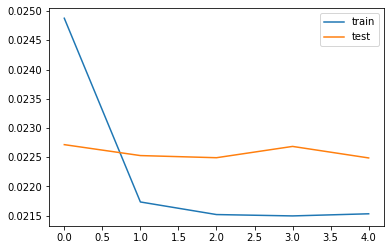

Calculating metrics
filename number 55
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.032924   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.378330   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.515714   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.029333   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046094   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.378330  
2   0.403581   0.909091        1.0  0.515714  
3   0.414601   0.870130        1.0  0.029333  
4   0.414601   0.870130        1.0  0.046094  
5   0.362948   0.883117        1.0  0.015265  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 74us/step - loss: 0.0418 - val_loss

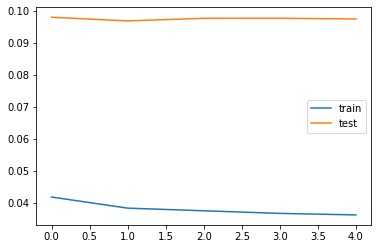

Calculating metrics
filename number 56
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041449   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.018930   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.017624   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.013381   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007833   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.018930  
2   0.403581   0.909091        1.0  0.017624  
3   0.414601   0.870130        1.0  0.013381  
4   0.414601   0.870130        1.0  0.007833  
5   0.362948   0.883117        1.0  0.011423  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0259 - val_loss

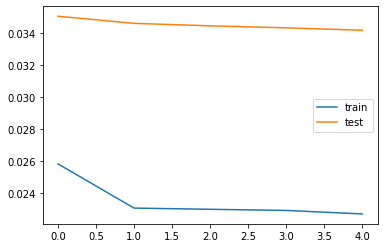

Calculating metrics
filename number 57
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.155600   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.118930   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.169475   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.136769   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.111001   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.118930  
2   0.403581   0.909091        1.0  0.169475  
3   0.414601   0.870130        1.0  0.136769  
4   0.414601   0.870130        1.0  0.111001  
5   0.362948   0.883117        1.0  0.100099  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 83us/step - loss: 0.0494 - val_loss

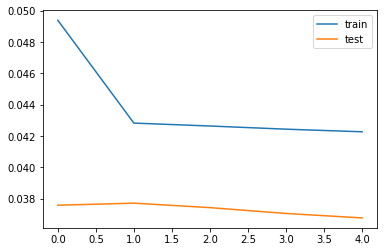

Calculating metrics
filename number 58
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.019808   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.011319   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.020374   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.153933   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.068478   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.011319  
2   0.403581   0.909091        1.0  0.020374  
3   0.414601   0.870130        1.0  0.153933  
4   0.414601   0.870130        1.0  0.068478  
5   0.362948   0.883117        1.0  0.061121  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0232 - val_loss

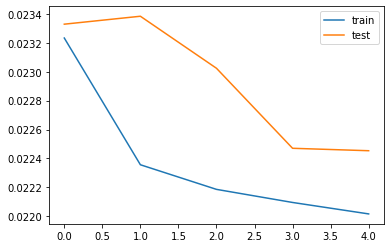

Calculating metrics
filename number 59
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.153269   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.150141   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.445105   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.252111   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.396622   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.150141  
2   0.403581   0.909091        1.0  0.445105  
3   0.414601   0.870130        1.0  0.252111  
4   0.414601   0.870130        1.0  0.396622  
5   0.362948   0.883117        1.0  0.154833  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0417 - val_loss

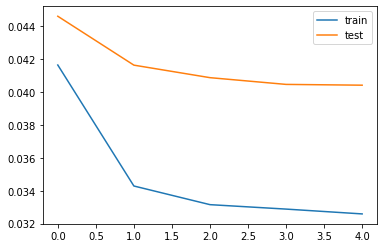

Calculating metrics
filename number 60
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.115245   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.074935   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.070801   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.056331   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.069767   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.074935  
2   0.403581   0.909091        1.0  0.070801  
3   0.414601   0.870130        1.0  0.056331  
4   0.414601   0.870130        1.0  0.069767  
5   0.362948   0.883117        1.0  0.055297  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0283 - val_loss

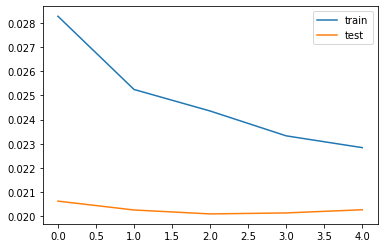

Calculating metrics
filename number 61
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064643   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.069702   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.051152   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044407   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.039348   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.069702  
2   0.403581   0.909091        1.0  0.051152  
3   0.414601   0.870130        1.0  0.044407  
4   0.414601   0.870130        1.0  0.039348  
5   0.362948   0.883117        1.0  0.032603  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0298 - val_loss

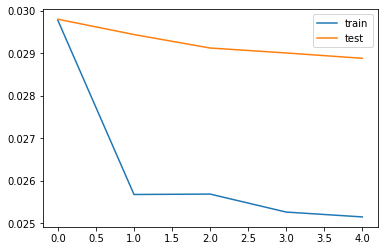

Calculating metrics
filename number 62
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028707   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.022290   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.036136   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.022627   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034110   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.022290  
2   0.403581   0.909091        1.0  0.036136  
3   0.414601   0.870130        1.0  0.022627  
4   0.414601   0.870130        1.0  0.034110  
5   0.362948   0.883117        1.0  0.024316  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0245 - val_loss

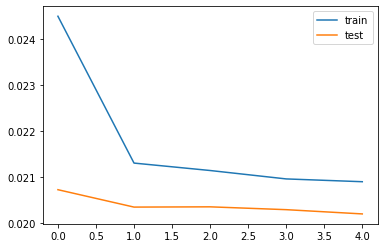

Calculating metrics
filename number 63
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.538288   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.355856   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.355856   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.361486   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.497748   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.355856  
2   0.403581   0.909091        1.0  0.355856  
3   0.414601   0.870130        1.0  0.361486  
4   0.414601   0.870130        1.0  0.497748  
5   0.362948   0.883117        1.0  0.371622  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0523 - val_loss

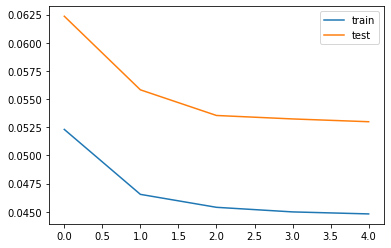

Calculating metrics
filename number 64
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.118635   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.092388   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.089239   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.082415   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.075066   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.092388  
2   0.403581   0.909091        1.0  0.089239  
3   0.414601   0.870130        1.0  0.082415  
4   0.414601   0.870130        1.0  0.075066  
5   0.362948   0.883117        1.0  0.130184  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0478 - val_loss

In [ ]:
# load the dataset
path = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/code_datasets/1_data_frames/multivariate/"
all_files = glob.glob(path + "/*.csv")

i = 0
mape_t = []
rmsle_t = []
for filename in all_files:
    i = i + 1
    print('filename number ' + str(i))
    df = pd.read_csv(filename,parse_dates = ['tstp'], index_col = ['tstp'])
    mape_i,rmsle_i = lstm_multivariate(df)
    mape_t.append(mape_i)
    rmsle_t.append(rmsle_i)

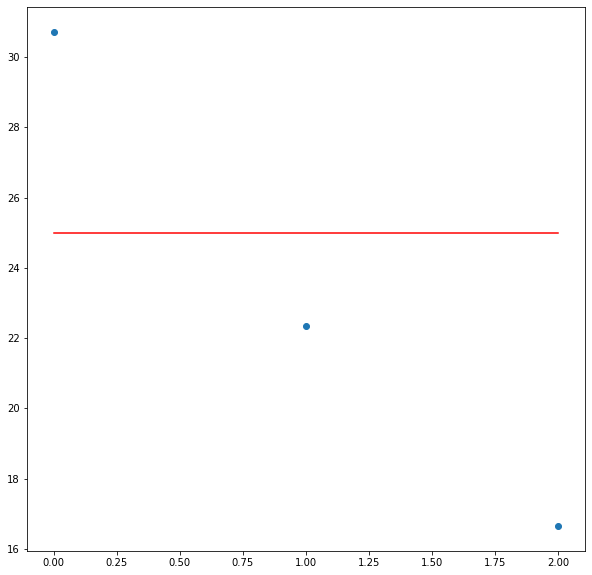

In [19]:
plt.figure(figsize = (10,10))
plt.scatter(range(348),mape_t)
plt.plot(range(348),[25]*348,color = 'red')
plt.show()

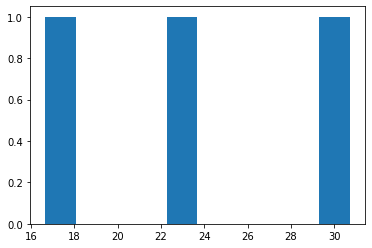

In [20]:
plt.hist(mape_t)
plt.show()

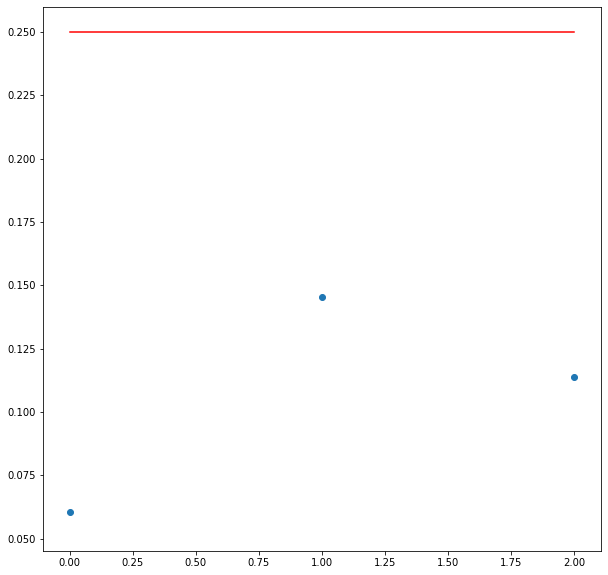

In [21]:
plt.figure(figsize = (10,10))
plt.scatter(range(348),rmsle_t)
plt.plot(range(348),[0.25]*348,color = 'red')
plt.show()

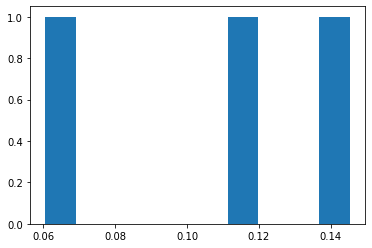

In [22]:
plt.hist(rmsle_t)
plt.show()